# HierMinimax

Expeirments for the convex case.

## Installation

In [ ]:
# if you are using Google Colab, all required packages are already installed.
# otherwise, uncomment the following commands (if the pip command does not work, please try to change !pip to !pip3 for all the commands)

# !pip install numpy
# !pip install matplotlib
# !pip install torch
# !pip install tensorflow
# !pip install tensorflow_datasets
# !pip install gdown

## Utilities

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

import os
from collections import Counter
import itertools
import time
import json
import gdown

######################### Results Utilities #################################
project_folder = './'
results_path = os.path.join(project_folder, 'results')
images_path = os.path.join(project_folder, 'images')
os.makedirs(results_path, exist_ok=True)
os.makedirs(images_path, exist_ok=True)


def save_results(result_name, accuracy, loss, accuracy_per_domain, loss_per_domain, result_extension='npy'):
    path = os.path.join(results_path, result_name + "." + result_extension)
    with open(path, 'wb') as f:
        np.save(f, accuracy)
        np.save(f, loss)
        np.save(f, accuracy_per_domain)
        np.save(f, loss_per_domain)

def load_results(result_name, result_extension='npy'):
    path = os.path.join(results_path, result_name + "." + result_extension)
    with open(path, 'rb') as f:
        accuracy = np.load(f)
        loss = np.load(f)
        accuracy_per_domain = np.load(f)
        loss_per_domain = np.load(f)
    return accuracy, loss, accuracy_per_domain, loss_per_domain

######################### Plotting Utilities #################################
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(images_path, fig_id + "." + fig_extension)
    print("Saving figure: ", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

def plot_metric_over_rounds(results, figure_name, metric='accuracy', save=False):
    xpoints = np.arange(results.shape[0])
    plt.plot(xpoints, results)
    plt.xlabel("communication rounds")
    plt.ylabel(metric)
    plt.grid(True)
    # plt.title(f"{metric} over rounds")
    print(f"{metric} over rounds")
    if save:
        save_fig(figure_name)
    plt.show()

from mpl_toolkits.axes_grid1.inset_locator import mark_inset
def plot_metric_over_rounds_over_tau(results, figure_name, legend, metric='accuracy', detail=False, save=False):
    if not detail:
        xpoints = np.arange(results[0].shape[0])
        num_curves = len(results)
        fmt = ['-o', '-*', '-^', 's-', 'D-']
        fmt = fmt[:num_curves]
        colors = ['#2ca02c', '#ff7f0e', '#1f77b4', '#9467bd','#d62728']
        for i, result in enumerate(results):
            plt.plot(xpoints, result, fmt[i], linewidth=0.6, markersize=4, markevery=1500, color=colors[i])
        plt.xlabel("communication rounds", fontsize="15")
        plt.ylabel(metric, fontsize="15")
        plt.grid(True)
        plt.legend(legend, fontsize="13")
        if save:
            save_fig(figure_name)
        plt.show()
    else:
        fig, ax = plt.subplots(1,1)
        num_curves = len(results)
        fmt = ['-o', '-*', '-^', 's-', 'D-']
        fmt = fmt[:num_curves]
        xpoints = np.arange(results[0].shape[0])
        for i, result in enumerate(results):
            ax.plot(xpoints, result, fmt[i], linewidth=0.6, markersize=4, markevery=1500)
        axins = ax.inset_axes((0.5, 0.37, 0.4, 0.3))
        for i, result in enumerate(results):
            axins.plot(xpoints, result, fmt[i], linewidth=0.6, markersize=4, markevery=1500)

        # set zoom
        zone_left, zone_right = 950, 1050
        # set ratio
        x_ratio, y_ratio = 0.5, 0.5

        # set range of x
        xlim0 = xpoints[zone_left]-(xpoints[zone_right]-xpoints[zone_left])*x_ratio
        xlim1 = xpoints[zone_right]+(xpoints[zone_right]-xpoints[zone_left])*x_ratio

        # set range of y
        y = np.hstack((results[0][zone_left:zone_right], results[1][zone_left:zone_right], results[2][zone_left:zone_right], results[3][zone_left:zone_right]))
        ylim0 = np.min(y)-(np.max(y)-np.min(y))*y_ratio
        ylim1 = np.max(y)+(np.max(y)-np.min(y))*y_ratio

        axins.set_xlim(xlim0, xlim1)
        axins.set_ylim(ylim0, ylim1)

        # loc1 loc2:
        # 1 (topright) 2 (topleft) 3 (bottomleft) 4 (bottomright)
        if  metric == 'accuracy':
            mark_inset(ax, axins, loc1=1, loc2=2, fc="none", ec='k', lw=1)
        elif metric == 'worst accuracy':
            mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec='k', lw=1)
        elif metric == 'loss':
            mark_inset(ax, axins, loc1=2, loc2=3, fc="none", ec='k', lw=1)

        ax.set_xlabel('communication rounds')
        ax.set_ylabel(metric)
        ax.grid(True)
        ax.legend(legend)
        if save:
            save_fig(figure_name)
        plt.show()

def plot_metric_over_iterations_over_tau(results, figure_name, legend, tau_list, metric='accuracy', save=False):
    num_curves = len(results)
    fmt = ['-o', '-*', '-^', 's-', 'D-']
    fmt = fmt[:num_curves]
    for i, result in enumerate(results):
        tau = tau_list[i][0] * tau_list[i][1]
        xpoints = np.arange(0, 1+(result.shape[0]-1)*tau, tau)
        plt.plot(xpoints, result, fmt[i], linewidth=0.6, markersize=4, markevery=1500)
    plt.xlabel("iterations")
    plt.ylabel(metric)
    plt.grid(True)
    plt.legend(legend)
    if save:
        save_fig(figure_name)
    plt.show()


def plot_test_accuracy_per_domain(accuracies_per_domain):
    # label_to_description = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover",
    #                     3: "Dress", 4: "Coat", 5: "Sandal", 6: "Shirt",
    #                     7: "Sneaker", 8: "Bag", 9: "Ankle boot"}
    label_to_description = {0: "0", 1: "1", 2: "2",
                        3: "3", 4: "4", 5: "5", 6: "6",
                        7: "7", 8: "8", 9: "9"}
    plt.bar(np.arange(10), accuracies_per_domain)
    for i in range(10):
        plt.text(i, accuracies_per_domain[i], f"{accuracies_per_domain[i]:.3f}", ha = 'center')
    plt.xticks(np.arange(10), [label_to_description[i] for i in range(10)], rotation=20)
    plt.ylim(0, 1)
    plt.show()



######################### Model Utilities #################################
class LogisticRegression(torch.nn.Module):
     def __init__(self, input_dim, output_dim):
         super(LogisticRegression, self).__init__()
         self.linear = torch.nn.Linear(input_dim, output_dim)

     def forward(self, x):
         logits = self.linear(x)
         return logits

def init_weights_LR(model):
    if isinstance(model, torch.nn.Linear):
        torch.nn.init.zeros_(model.weight)
        torch.nn.init.zeros_(model.bias)

class NN(torch.nn.Module):
    def __init__(self, input_dimension, num_classes):
        super().__init__()
        self.fc1 = torch.nn.Sequential(
            torch.nn.Linear(input_dimension, 300),
            torch.nn.ReLU())
        self.fc2 = torch.nn.Sequential(
            torch.nn.Linear(300, 100),
            torch.nn.ReLU())
        self.fc3 = torch.nn.Sequential(
            torch.nn.Linear(100, num_classes)
            )

    def forward(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

def calculate_weighted_parameters(local_params_list, weights=None):
    """
    weighted average of local model parameters
    result = \sum_{i}^{n} weight[i] * local_parameters[i]
    """
    n = len(local_params_list)
    if weights is None:
        weights = np.array([1.0/n] * n)
    new_global_params = local_params_list[0].copy()

    for key in new_global_params.keys(): # for each layer
        new_global_params[key] = torch.zeros_like(new_global_params[key])
        for i in range(n): # summation of weight * local_parameter
            new_global_params[key] += weights[i]*local_params_list[i][key]
    return new_global_params

def project_to_probability(v, s=1):
    assert s > 0, "Radius s must be strictly positive "
    v = torch.from_numpy(v)
    n, = v.shape
    if v.sum() == s and (v >= 0).all():
        return v
    u =  torch.flip(torch.sort(v)[0],dims=(0,)) # sorted v of decreasing order
    cssv = torch.cumsum(u, dim=0) # cumulative sum of decreasingly sorted v
    # get the number of > 0 components of the optimal solution
    non_zero_vector = torch.nonzero(u * torch.arange(1, n+1) > (cssv - s), as_tuple=False)
    if len(non_zero_vector) == 0:
        rho = 0.0
    else:
        rho = non_zero_vector[-1].squeeze()
    theta = (cssv[rho] - s) / (rho + 1.0) # compute the Lagrange multiplier associated to the simplex constraint
    w = (v - theta).clamp(min=0) # compute the projection by thresholding v using theta
    w = w.numpy()
    return w

######################### Dataset Utilities #################################
def load_synthetic(num_distribution=10):
    def load_synthetic_helper(split='train'):
        datasets_folder = './drive/MyDrive/Datasets/'
        dataset_name = 'Synthetic'
        dataset_path = os.path.join(datasets_folder, dataset_name)

        filename = os.path.join(dataset_path, f'{split}.json')

        with open(filename) as f:
            data = json.load(f)

        all_X = []
        all_y = []
        for i in range(num_distribution):
            all_X.append(np.array(data['user_data']['f_000' + str(i).zfill(2)]['x']))
            all_y.append(np.array(data['user_data']['f_000' + str(i).zfill(2)]['y']))

        X = np.concatenate(all_X, axis=0)
        y = np.concatenate(all_y, axis=0)
        print(f"{split} X: {X.shape}, y: {y.shape}")
        return X, y

    X_train, y_train = load_synthetic_helper(split='train')
    X_test, y_test = load_synthetic_helper(split='test')
    return X_train, y_train, X_test, y_test

def load_synthetic_per_domain(num_distribution=10):
    def load_synthetic_per_domain_helper(split='train'):
        datasets_folder = './drive/MyDrive/Datasets/'
        dataset_name = 'Synthetic'
        dataset_path = os.path.join(datasets_folder, dataset_name)

        filename = os.path.join(dataset_path, f'{split}.json')

        with open(filename) as f:
            data = json.load(f)

        per_domain_data = {}
        for i in range(num_distribution):
            per_domain_data[i] = (np.array(data['user_data']['f_000' + str(i).zfill(2)]['x']), np.array(data['user_data']['f_000' + str(i).zfill(2)]['y']))
            print(f"{split} of domain {i}, X: {per_domain_data[i][0].shape}, y: {per_domain_data[i][1].shape}")
        return per_domain_data

    per_domain_training_data = load_synthetic_per_domain_helper(split='train')
    per_domain_test_data = load_synthetic_per_domain_helper(split='test')
    return per_domain_training_data, per_domain_test_data


def load_dataset(sys_specs, model_name, dataset_name, seed=0):
    np.random.seed(seed)
    if dataset_name in ["MNIST", "Fashion-MNIST"]:
        if dataset_name == "MNIST":
            (X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
        else:
            (X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
        X_train = X_train_full / 255. # (60000, 28, 28)
        X_test = X_test / 255. # (10000, 28, 28)
        if model_name in ["LR", "NN"]: # LR or full-connected network
            X_train = X_train.reshape(X_train.shape[0], -1) # (60000, 764)
            X_test = X_test.reshape(X_test.shape[0], -1) # (10000, 764)
        else: # CNN
            X_train = np.expand_dims(X_train, axis=1) # (N, C, H, W) = (60000, 1, 28, 28)
            X_test = np.expand_dims(X_test, axis=1) # (10000, 1, 28, 28)
        y_train = y_train_full # (N,)
    elif dataset_name in ["EMNIST"]:
        try:
            (X_train_full, y_train_full), (X_test, y_test) = tfds.as_numpy(tfds.load('emnist/digits', split=['train', 'test'], batch_size=-1,as_supervised=True,))
        except:
            print("An exception occurred for loading EMNIST-Digits from tfds.")
            print("Starting to load from local copy.")
            if not os.path.exists('./Datasets/EMNIST-Digits'):
                print("Loading started.")
                os.system("mkdir ./Datasets")
                os.system("mkdir ./Datasets/EMNIST-Digits")
                os.system("gdown https://drive.google.com/drive/folders/1Wq3rOGSMdKJ2tuKOQv6VMXShLOTf1YhH -O ./Datasets/EMNIST-Digits --folder")
                print("Loading completed.")
            # !pip install gdown
            # !mkdir ./Datasets
            # !mkdir ./Datasets/EMNIST-Digits
            # !gdown https://drive.google.com/drive/folders/1Wq3rOGSMdKJ2tuKOQv6VMXShLOTf1YhH -O ./Datasets/EMNIST-Digits --folder
            datasets_folder = './Datasets/'
            dataset_name = 'EMNIST-Digits'
            dataset_path = os.path.join(datasets_folder, dataset_name)

            training_filename = os.path.join(dataset_path, 'emnist-digits-train.csv')
            test_filename = os.path.join(dataset_path, 'emnist-digits-test.csv')

            train = np.genfromtxt(training_filename, delimiter=',')
            X_train_full, y_train_full = train[:, 1:], train[:, 0].astype(np.uint8)
            X_train_full = X_train_full.reshape(X_train_full.shape[0], 28, 28, 1, order='F')
            test = np.genfromtxt(test_filename, delimiter=',')
            X_test, y_test = test[:, 1:], test[:, 0].astype(np.uint8)
            X_test = X_test.reshape(X_test.shape[0], 28, 28, 1, order='F')
        X_train = X_train_full / 255. # (24000, 28, 28, 1)
        X_test = X_test / 255. # (4000, 28, 28, 1)
        if model_name in ["LR", "NN"]: # LR or full-connected network
            X_train = X_train.reshape(X_train.shape[0], -1) # (24000, 764)
            X_test = X_test.reshape(X_test.shape[0], -1) # (4000, 764)
        else: # CNN
            X_train = np.transpose(X_train, axis=(0,3,1,2)) # (N, C, H, W) = (24000, 1, 28, 28)
            X_test = np.expand_dims(X_test, axis=(0,3,1,2)) # (4000, 1, 28, 28)
        y_train = y_train_full # (N,)
    elif dataset_name in ["Synthetic"]:
        X_train, y_train, X_test, y_test = load_synthetic(sys_specs["NE"])
    else:
        print(f"Dataset {dataset_name} is not available.")
        return

    # create per-domain data
    if "MNIST" in dataset_name:
        per_domain_training_data = {}
        for i in range(sys_specs["NE"]):
            X_train_i = X_train[y_train == i, :]
            per_domain_training_data[i] = (X_train_i, np.full((X_train_i.shape[0],), i, dtype=int))
        per_domain_test_data = {}
        for i in range(sys_specs["NE"]):
            X_test_i = X_test[y_test == i, :]
            per_domain_test_data[i] = (X_test_i, np.full((X_test_i.shape[0],), i, dtype=int))
    elif dataset_name == "Synthetic":
        per_domain_training_data, per_domain_test_data = load_synthetic_per_domain(sys_specs["NE"])

    test_size = sys_specs["test_size"]
    test_data = (X_test[:test_size], y_test[:test_size])
    return per_domain_training_data, test_data, per_domain_test_data, sys_specs

def test_all_domains(test_data, model, loss_fn):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    X_test, y_test = test_data
    X_test, y_test = torch.from_numpy(X_test.copy()).type(torch.float).to(device), torch.from_numpy(y_test.copy()).type(torch.int64).to(device)
    model.eval()
    with torch.no_grad():
        pred_t = model(X_test)
        correct_t = (pred_t.argmax(1) == y_test).type(torch.float).sum().item()
        correct_t /= X_test.shape[0]
        loss_t = loss_fn(pred_t, y_test).item()
    return correct_t, loss_t

def test_per_domain(X, y, model, loss_fn):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    size = X.size(dim=0)
    model.eval()
    test_loss, test_accuracy = 0, 0
    with torch.no_grad():
        X, y = X.to(device), y.to(device)
        pred = model(X)
        test_loss += loss_fn(pred, y).item()
        test_accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_accuracy /= size
    return test_accuracy, test_loss

######################### Methods #################################
def train_HierFedAvg(per_domain_training_data, test_data, per_domain_test_data, sys_specs, model_name, seed, sample_prob='uniform'):
    """
    HierFedAvg
    """
    K = sys_specs["K"] # number of rounds
    tau_1 = sys_specs["tau_1"] # number of local iterations
    tau_2 = sys_specs["tau_2"] # number of local aggregation
    tau = tau_1 * tau_2
    T = K * tau # number of iterations
    N = sys_specs["N"] # number of clients
    NE = sys_specs["NE"] # number of edges
    N0 = N // NE # number of clients per edge
    m = sys_specs["m2"] # number of sampled edges
    C = sys_specs["C"] # number of classes
    d = sys_specs["d"] # dimension of features
    learning_rate = sys_specs["learning_rate"]
    ute = np.zeros(shape=(K+1,NE)) # sampled edges with corresponding weights
    batch_size = sys_specs["batch_size"]
    assert N % NE == 0, "Same number of clients in each edge"
    print("T:", T, " N:", N)

    accuracy = np.zeros(K+1)
    loss = np.zeros(K+1)
    accuracy_per_domain = np.zeros((K+1, NE))
    loss_per_domain = np.zeros((K+1, NE))

    np.random.seed(seed)
    torch.manual_seed(seed)
    loss_fn = torch.nn.CrossEntropyLoss()
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # model initialization
    if model_name == "LR":
        global_model = LogisticRegression(d, C)
        global_model.apply(init_weights_LR) # initialize parameters to zeros
        global_model.to(device)

        local_models = [LogisticRegression(d, C) for _ in range(N)]
        for i in range(N):
            local_models[i].apply(init_weights_LR)
            local_models[i].to(device)
    elif model_name == "NN":
        global_model = NN(d, C)
        global_model.to(device)
        local_models = [NN(d, C) for _ in range(N)]
        for i in range(N):
            local_models[i].to(device)
            local_models[i].load_state_dict(global_model.state_dict().copy())
    else:
        print("unknown model")

    # evalute initial model
    accuracy[0] , loss[0] = test_all_domains(test_data, global_model, loss_fn)
    print(f"Before training: overall test accuracy {accuracy[0]:.4f}, test loss {loss[0]:.4f}")
    X_test, y_test = test_data
    for i in range(C):
        accuracy_per_domain[0, i], loss_per_domain[0, i] = test_per_domain(torch.from_numpy(per_domain_test_data[i][0]).type(torch.float), torch.from_numpy(per_domain_test_data[i][1]).type(torch.int64), global_model, loss_fn)

    for k in range(1, K+1):
        # update scheduling indicator: u
        if sample_prob == 'uniform':
            idx = np.random.permutation(NE)[:m]
            ute[k, idx] = 1.0
        elif sample_prob == 'random':
            ute[k, :] = np.random.multinomial(m, (1.0/NE)*np.ones(NE)).astype(float)

        for t2 in range(tau_2):
            for t1 in range(tau_1):
                t = (k-1)*tau+t2*tau_1+t1
                for i in range(N):
                    if ute[k, i//N0] > 0:
                        local_models[i].train()
                        loss_fn = torch.nn.CrossEntropyLoss()
                        optimizer = torch.optim.SGD(local_models[i].parameters(), lr=learning_rate)
                        indices = np.random.randint(per_domain_training_data[i//N0][0].shape[0], size=batch_size) # select indices of samples
                        X, y = (per_domain_training_data[i//N0][0][indices, :], per_domain_training_data[i//N0][1][indices])
                        X, y = torch.from_numpy(X).type(torch.float).to(device), torch.from_numpy(y).type(torch.int64).to(device)

                        # Compute prediction error
                        pred = local_models[i](X)
                        loss_train = loss_fn(pred, y)

                        # Backpropagation
                        optimizer.zero_grad()
                        loss_train.backward()
                        optimizer.step()
                    else:
                        pass # do not update local model
            # local aggregation
            local_params_list = [local_models[i].state_dict().copy() for i in range(N)]
            edge_params_list =  [calculate_weighted_parameters(local_params_list[i*N0:(i+1)*N0]) for i in range(NE)]
            for i in range(N):
                local_models[i].load_state_dict(edge_params_list[i//N0])
        weights = ute[k, :]
        weights /= np.sum(weights)
        global_params = calculate_weighted_parameters(edge_params_list, weights=weights)
        global_model.load_state_dict(global_params)
        # server broadcast
        for i in range(N):
            local_models[i].load_state_dict(global_params)

        correct_t , loss_t = test_all_domains(test_data, global_model, loss_fn)
        accuracy[k] = correct_t
        loss[k] = loss_t
        for i in range(NE):
            accuracy_per_domain[k, i], loss_per_domain[k, i] = test_per_domain(torch.from_numpy(per_domain_test_data[i][0]).type(torch.float), torch.from_numpy(per_domain_test_data[i][1]).type(torch.int64), global_model, loss_fn)

        worst_accuracy = np.min( accuracy_per_domain[k, :])
        if k % 200 == 0:
            print(f"After round {k}: accuracy {accuracy[k]:.4f}, loss {loss[k]:.4f}, and worst distribution accuracy {worst_accuracy}.")
    return accuracy, loss, accuracy_per_domain, loss_per_domain

def train_HierMinimax(per_domain_training_data, test_data, per_domain_test_data, sys_specs, model_name, seed):
    """
    Hierarchical Minimax Optimization
    """
    K = sys_specs["K"] # number of rounds
    tau_1 = sys_specs["tau_1"]
    tau_2 = sys_specs["tau_2"]
    tau = tau_1 * tau_2
    T = K * tau
    N = sys_specs["N"] # number of clients
    NE = sys_specs["NE"] # number of edges
    N0 = N // NE # number of clients per edge
    m = sys_specs["m2"] # number of sampled edges
    C = sys_specs["C"] # number of classes
    d = sys_specs["d"] # dimension of features
    learning_rate = sys_specs["learning_rate"]
    eta_q = sys_specs["eta_q"]

    batch_size = sys_specs["batch_size"]
    assert N % NE == 0, "Same number of clients in each edge"
    print("T:", T, " N:", N)

    ute = np.zeros(shape=(K+1,NE)) # sampled edges for updating w with corresponding weights
    ute_q = np.zeros(shape=(K+1,NE)) # sampled edges for updating q with corresponding weights
    q = np.zeros(shape=(K+1,NE)) # weight vector
    q[0,:] = np.full(NE, 1/NE)

    accuracy = np.zeros(K+1)
    loss = np.zeros(K+1)
    accuracy_per_domain = np.zeros((K+1, NE))
    loss_per_domain = np.zeros((K+1, NE))

    np.random.seed(seed)
    torch.manual_seed(seed)
    loss_fn = torch.nn.CrossEntropyLoss()
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # model initialization
    if model_name == "LR":
        global_model = LogisticRegression(d, C)
        global_model.apply(init_weights_LR) # initialize parameters to zeros
        global_model.to(device)
        dummy_model = LogisticRegression(d, C) # dummy model for updating q
        dummy_model.apply(init_weights_LR)
        dummy_model.to(device)

        local_models = [LogisticRegression(d, C) for _ in range(N)]
        for i in range(N):
            local_models[i].apply(init_weights_LR)
            local_models[i].to(device)
    elif model_name == "NN":
        global_model = NN(d, C)
        global_model.to(device)
        dummy_model = NN(d, C)
        dummy_model.to(device)
        dummy_model.load_state_dict(global_model.state_dict().copy())
        local_models = [NN(d, C)  for _ in range(N)]
        for i in range(N):
            local_models[i].to(device)
            local_models[i].load_state_dict(global_model.state_dict().copy())

    # evalute initial model
    accuracy[0] , loss[0] = test_all_domains(test_data, global_model, loss_fn)
    print(f"Before training: overall test accuracy {accuracy[0]:.4f}, test loss {loss[0]:.4f}")
    for i in range(NE):
        accuracy_per_domain[0, i], loss_per_domain[0, i] = test_per_domain(torch.from_numpy(per_domain_test_data[i][0]).type(torch.float), torch.from_numpy(per_domain_test_data[i][1]).type(torch.int64), global_model, loss_fn)

    for k in range(1, K+1):
        # update scheduling indicator: u
        ute[k, :] = np.random.multinomial(m, q[k-1,:]).astype(float)
        tau_1_prime = np.random.randint(0, tau_1) # uniform integer in [0, tau_1)
        tau_2_prime = np.random.randint(0, tau_2) # uniform integer in [0, tau_2)
        local_params_list_prime = [local_models[i].state_dict().copy() for i in range(N)] # placeholder

        # local updates
        for t2 in range(tau_2):
            for t1 in range(tau_1):
                t = (k-1)*tau+t2*tau_1+t1
                for i in range(N):
                    if ute[k, i//N0] > 0:
                        local_models[i].train()
                        loss_fn = torch.nn.CrossEntropyLoss()
                        optimizer = torch.optim.SGD(local_models[i].parameters(), lr=learning_rate)
                        indices = np.random.randint(per_domain_training_data[i//N0][0].shape[0], size=batch_size) # select indices of samples
                        X, y = (per_domain_training_data[i//N0][0][indices, :], per_domain_training_data[i//N0][1][indices])
                        X, y = torch.from_numpy(X).type(torch.float).to(device), torch.from_numpy(y).type(torch.int64).to(device)

                        # Compute prediction error
                        pred = local_models[i](X)
                        loss_train = loss_fn(pred, y)

                        # Backpropagation
                        optimizer.zero_grad()
                        loss_train.backward()
                        optimizer.step()
                        if t1 == tau_1_prime and t2 == tau_2_prime:
                            local_params_list_prime[i] = local_models[i].state_dict().copy()
                    else:
                        pass # do not update local model

            # local aggregation
            local_params_list = [local_models[i].state_dict().copy() for i in range(N)]
            edge_params_list =  [calculate_weighted_parameters(local_params_list[i*N0:(i+1)*N0]) for i in range(NE)]
            for i in range(N):
                local_models[i].load_state_dict(edge_params_list[i//N0])

        weights = ute[k, :]
        weights /= np.sum(weights)
        global_params = calculate_weighted_parameters(edge_params_list, weights=weights)
        global_model.load_state_dict(global_params)

        # server broadcast
        for i in range(N):
            local_models[i].load_state_dict(global_params)

        # server aggregation to update q
        edge_params_list_prime =  [calculate_weighted_parameters(local_params_list_prime[i*N0:(i+1)*N0]) for i in range(NE)]
        global_params_prime = calculate_weighted_parameters(edge_params_list_prime, weights=weights)
        dummy_model.load_state_dict(global_params_prime)
        idx = np.random.permutation(NE)[:m]
        ute_q[k, idx] = 1.0
        v = np.zeros(N)
        for i in range(N):
            if ute_q[k,i//N0] > 0: # sampled
                with torch.no_grad():
                    indices = np.random.randint(per_domain_training_data[i//N0][0].shape[0], size=batch_size) # select indices of samples
                    X, y = (per_domain_training_data[i//N0][0][indices, :], per_domain_training_data[i//N0][1][indices])
                    X, y = torch.from_numpy(X).type(torch.float).to(device), torch.from_numpy(y).type(torch.int64).to(device)
                    pred = local_models[i](X)
                    v[i] = loss_fn(pred, y).item()
        v = np.average(v.reshape(-1, N0), axis=1)
        q_temp = q[k-1, :]+(NE*tau*eta_q/m)*v
        q[k, :] = project_to_probability(q_temp)

        # evaluate over all test data
        correct_t , loss_t = test_all_domains(test_data, global_model, loss_fn)
        accuracy[k] = correct_t
        loss[k] = loss_t

        for i in range(NE):
            accuracy_per_domain[k, i], loss_per_domain[k, i] = test_per_domain(torch.from_numpy(per_domain_test_data[i][0]).type(torch.float), torch.from_numpy(per_domain_test_data[i][1]).type(torch.int64), global_model, loss_fn)
        worst_accuracy = np.min(accuracy_per_domain[k, :])
        if k % 200 == 0:
            print(f"After round {k}: accuracy {accuracy[k]:.4f}, loss {loss[k]:.4f}, and worst distribution accuracy {worst_accuracy}.")
            print("q", q[k, :])
    return accuracy, loss, accuracy_per_domain, loss_per_domain


def run_experiments(method, model_name, dataset_name, sys_specs):
    if dataset_name == "Fashion-MNIST":
        label_to_description = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover",
                                3: "Dress", 4: "Coat", 5: "Sandal", 6: "Shirt",
                                7: "Sneaker", 8: "Bag", 9: "Ankle boot"}
    else:
        label_to_description = {}
        for i in range(sys_specs["C"]):
            label_to_description[i] = str(i)
    seed = 0
    per_domain_training_data, test_data, per_domain_test_data, sys_specs = load_dataset(sys_specs, model_name, dataset_name, seed)
    if method == "HierFedAvg":
        accuracy, loss, accuracy_per_domain, loss_per_domain = train_HierFedAvg(per_domain_training_data, test_data, per_domain_test_data, sys_specs, model_name, seed, sample_prob='uniform')
    elif method == "HierRandom":
        accuracy, loss, accuracy_per_domain, loss_per_domain = train_HierFedAvg(per_domain_training_data, test_data, per_domain_test_data, sys_specs, model_name, seed, sample_prob='random')
    elif method == "HierMinimax":
        accuracy, loss, accuracy_per_domain, loss_per_domain = train_HierMinimax(per_domain_training_data, test_data, per_domain_test_data, sys_specs, model_name, seed)
    else:
        print(f"Method {method} is not defined")
    return accuracy, loss, accuracy_per_domain, loss_per_domain


## Training

In [ ]:
# HierFedAvg, HierMinimax
sys_specs = {
    "batch_size": 1,
    "learning_rate": 1e-3,
    "eta_q": 1e-3,
    "C": 10, # number of classes
    "N": 30, # number of clients
    "NE": 10, # number of edges
    "m2": 5, # number of sampled edges
    "K": 20000, # number of rounds
    "tau_1": 1, # number of local SGD iterations
    "tau_2": 1, # number of local aggregation
    "d": 784, # dimension
    "test_size": 1000
}

model_names = ["LR"]
methods = ["HierFedAvg", "HierMinimax"]
dataset_names = ["EMNIST"]

for tau_1 in [1, 2]:
    sys_specs['tau_1'] = tau_1
    for tau_2 in [1, 2]:
        sys_specs['tau_2'] = tau_2
        for dataset_name in dataset_names:
            for model_name in model_names:
                for method in methods:
                    result_name = f"{dataset_name}-{model_name}-{method}-N{sys_specs['N']}-NE{sys_specs['NE']}-m{sys_specs['m2']}"+\
                    f"-K{sys_specs['K']}-tau{sys_specs['tau_1']}-{sys_specs['tau_2']}-batch{sys_specs['batch_size']}-stepsize{sys_specs['learning_rate']}" + (f"-{sys_specs['eta_q']}" if method == "HierMinimax" else "")
                    print(result_name)
                    accuracy, loss, accuracy_per_domain, loss_per_domain = run_experiments(method, model_name, dataset_name, sys_specs)
                    save_results(result_name, accuracy, loss, accuracy_per_domain, loss_per_domain)
                    plot_metric_over_rounds(accuracy, "", "accuracy")
                    plot_metric_over_rounds(loss, "", "loss")
                    worst_accuracies = np.min(accuracy_per_domain, axis=1)
                    for i in range(1, worst_accuracies.size):
                        worst_accuracies[i] = (worst_accuracies[i-1]*(i-1) + worst_accuracies[i])/i
                    plot_metric_over_rounds(worst_accuracies, "", "worst-accuracy")
                    plot_test_accuracy_per_domain(accuracy_per_domain[-1, :])


EMNIST-LR-HierFedAvg-N30-NE10-m5-K20000-tau1-1-batch1-stepsize0.001


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/240000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/digits/incomplete.IWBX3A_3.1.0/emnist-train.array_record*...:   0%|…

Generating test examples...:   0%|          | 0/40000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/digits/incomplete.IWBX3A_3.1.0/emnist-test.array_record*...:   0%| …

Dataset emnist downloaded and prepared to /root/tensorflow_datasets/emnist/digits/3.1.0. Subsequent calls will reuse this data.
An exception occurred for loading EMNIST-Digits from tfds.
Starting to load from local copy.
T: 20000  N: 30
Before training: overall test accuracy 0.1230, test loss 2.3026
After round 200: accuracy 0.6860, loss 2.0738, and worst distribution accuracy 0.06025.


KeyboardInterrupt: 

## Plotting

(20001,)
shape (20001, 10)
HierMinimax, 0.8771, 0.8104
(1, 1) HierMinimax
(20001,)
shape (20001, 10)
HierFedAvg, 0.8929, 0.7624
(2, 1) HierFedAvg
(20001,)
shape (20001, 10)
HierMinimax, 0.8905, 0.8255
(2, 1) HierMinimax
(20001,)
shape (20001, 10)
HierFedAvg, 0.9065, 0.8050
(2, 2) HierFedAvg
(20001,)
shape (20001, 10)
HierMinimax, 0.8994, 0.8334
(2, 2) HierMinimax
EMNIST-LR-comparison-N30-NE10-m5-K20000-batch1-stepsize0.001-0.001


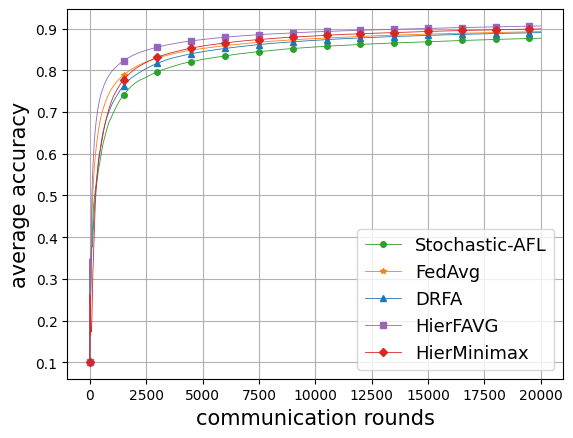

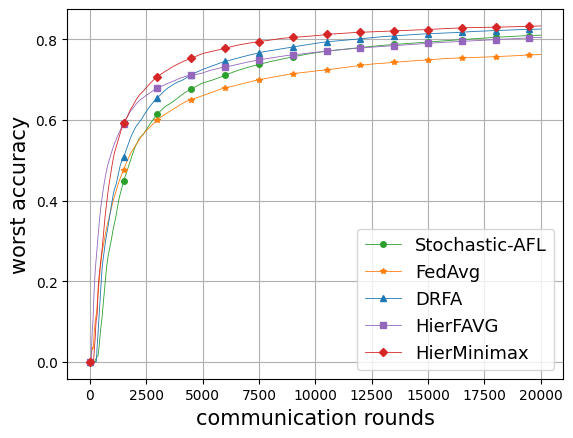

Number of rounds for Stochastic-AFL to achieve 0.8000026491940134 worst accuracy is: 16652
Number of rounds for DRFA to achieve 0.8000023287308271 worst accuracy is: 11727
Number of rounds for HierFAVG to achieve 0.8000030421258119 worst accuracy is: 18228
Number of rounds for HierMinimax to achieve 0.8000059694626875 worst accuracy is: 8200


In [ ]:
sys_specs = {
    "batch_size": 1,
    "learning_rate": 1e-3,
    "eta_q": 1e-3,
    "C": 10, # number of classes
    "N": 30, # number of clients
    "NE": 10, # number of edges
    "m2": 5, # number of sampled edges
    "K": 20000, # number of rounds
    "tau_1": 1, # number of local SGD iterations
    "tau_2": 1, # number of local aggregation
    "d": 784, # dimension
    "test_size": 10000
}

model_names = ["LR"]

# exponential moving average
def smooth(scalars, weight: float):
    if not isinstance(scalars, np.ndarray):
        scalars = np.array(scalars)
    assert scalars.ndim == 1
    assert weight >= 0 and weight <= 1
    num_scalars = scalars.size
    prev = scalars[0]
    smoothed = np.zeros(num_scalars)
    for idx in range(num_scalars):
        smoothed_val = prev * weight + (1 - weight) * scalars[idx]
        smoothed[idx] = smoothed_val
        prev = smoothed_val
    return smoothed

def calculate_time_average(metrics):
    duration = metrics.size
    for i in range(1, duration):
        metrics[i] = (metrics[i-1]*(i-1) + metrics[i])/i
    return metrics

methods = ["HierFedAvg", "HierMinimax"]
dataset_names = ["EMNIST"]

accuracy_list = []
loss_list = []
worst_accuracy_list = []
per_domain_accuracy_list = []
tau_list = [(1,1), (2,1), (2,2)]
for tau in tau_list:
    for dataset_name in dataset_names:
        for model_name in model_names:
            for method in methods:
                if tau in [(1,1)] and method in ["HierFedAvg"]: continue
                result_name = f"{dataset_name}-{model_name}-{method}-N{sys_specs['N']}-NE{sys_specs['NE']}-m{sys_specs['m2']}"+\
                f"-K{sys_specs['K']}-tau{tau[0]}-{tau[1]}-batch{sys_specs['batch_size']}-stepsize{sys_specs['learning_rate']}" + (f"-{sys_specs['eta_q']}" if method == "HierMinimax" else "")
                accuracy, loss, accuracy_per_domain, loss_per_domain = load_results(result_name)
                worst_accuracies = np.min(accuracy_per_domain, axis=1)
                # accuracy, loss, worst_accuracies = accuracy[:20000], loss[:20000], worst_accuracies[:20000]
                accuracy, loss, worst_accuracies = calculate_time_average(accuracy), calculate_time_average(loss), calculate_time_average(worst_accuracies)
                accuracy_per_domain = np.concatenate([calculate_time_average(np.expand_dims(accuracy_per_domain[:,i], axis=1)) for i in range(accuracy_per_domain.shape[1])], axis=1)
                per_domain_accuracy_list.append(accuracy_per_domain)
                worst_accuracy_list.append(worst_accuracies)
                accuracy_list.append(accuracy)

                print(result_name)
                print(f"{method}, {accuracy[-1]:.4f}, {worst_accuracies[-1]:.4f}")




legend = ["Stochastic-AFL", "FedAvg", "DRFA", "HierFAVG", "HierMinimax"]

plot_text = f"{dataset_name}-{model_name}-comparison-N{sys_specs['N']}-NE{sys_specs['NE']}-m{sys_specs['m2']}"+\
                f"-K{sys_specs['K']}-batch{sys_specs['batch_size']}-stepsize{sys_specs['learning_rate']}-{sys_specs['eta_q']}"
print(plot_text)
plot_metric_over_rounds_over_tau(accuracy_list, plot_text+"-accuracy_", legend, "average accuracy", detail=False, save=True)
plot_metric_over_rounds_over_tau(worst_accuracy_list, plot_text+"-worstaccuracy", legend, "worst accuracy", detail=False, save=True)


for i, algo in enumerate(legend):
    worst_accuracy = worst_accuracy_list[i]
    for j, value in enumerate(worst_accuracy):
        if value > 0.8:
            print(f"Number of rounds for {algo} to achieve {value} worst accuracy is: {j}")
            break
